# Tarea 5: Redes Recurrentes <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: 
Fecha de entrega: 30 de diciembre de 2020

In [16]:
import os

import torch
import torchvision
from torch import nn
from torch import tensor
from torch.nn import Embedding, RNN, Linear, CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from tqdm import tqdm

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea5/utils.py -q --show-progress

In [17]:
from utils import extract_text_from_set, extract_text_from_set, tokenize_text 
from utils import encode_sentences, pad_sequence_with_lengths, pad_sequence_with_images
from utils import TextDataset, CaptioningDataset

# Parte 1: Generación de texto

### Datos

In [18]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################

folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
    print('*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
    print('****** Descargando las imágenes...')
    !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip -P $folder_path/images -q --show-progress 
    print('********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
    !unzip -q $folder_path/images/Flickr8k_Dataset.zip -d $folder_path/images
    print('*** Descargando anotaciones de las imágenes...')
    !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations -q --show-progress

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset', ann_file = f'{folder_path}/annotations/8k-pictures.html')

print('Creando train, val y test splits...')
train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)

print('Listo!')

Inicializando pytorch Flickr8k dataset
Creando train, val y test splits...
Listo!


#### Extrae los textos

In [19]:
train_text = extract_text_from_set(train_flickr_set)
val_text = extract_text_from_set(val_flickr_set)
test_text = extract_text_from_set(test_flickr_set)

100%|██████████| 663/663 [00:00<00:00, 387031.81it/s]


#### Genera los tokens

In [20]:
tokenizer = get_tokenizer('spacy')
counter = Counter()  # para llevar la cuenta de los tokens y su ocurrencia

train_tokens, counter = tokenize_text(train_text, tokenizer, counter)
test_tokens, counter = tokenize_text(test_text, tokenizer, counter)
val_tokens, counter = tokenize_text(val_text, tokenizer, counter)

#### Define el vocabulario y agrega `<pad>` y `<sos>`

In [21]:
vocab = list(counter.keys())
vocab.append('<pad>')
vocab.append('<sos>')
word2idx = {word: i for i, word in enumerate(vocab)}
pad_idx = word2idx['<pad>']

#### Convierte oraciones a ids y genera los dataset de entrenamiento

In [22]:
train_sentences = encode_sentences(train_tokens, vocab, word2idx)
test_sentences = encode_sentences(test_tokens, vocab, word2idx)
val_sentences = encode_sentences(val_tokens, vocab, word2idx)

train_dataset = TextDataset(train_sentences)
test_dataset = TextDataset(test_sentences)
val_dataset = TextDataset(val_sentences)

Con todo lo anterior, además de tener los dataset para entrenamiento, podemos también obtener identificadores correspondientes a textos que nosotros decidamos, haciendo algo como lo siguiente:

In [23]:
s1 = 'A woman holding a cup of tea.'
s2 = 'A man with a dog.'

S = [s1,s2]
tokens, _ = tokenize_text(S, tokenizer)
D = encode_sentences(tokens, vocab, word2idx)

print('tokens:', tokens)
print('ids:', D)

tokens: [['<sos>', 'a', 'woman', 'holding', 'a', 'cup', 'of', 'tea', '.'], ['<sos>', 'a', 'man', 'with', 'a', 'dog', '.']]
ids: [[8460, 0, 238, 94, 0, 1570, 9, 1022, 14], [8460, 0, 78, 36, 0, 27, 14]]


#### Creamos los data loaders (puedes cambiar el tamaño del batch si lo deseas)



In [24]:
batch_size = 64

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, 
    collate_fn=lambda data_list: pad_sequence_with_lengths(data_list, pad_idx))
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, 
    collate_fn=lambda data_list: pad_sequence_with_lengths(data_list, pad_idx))
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, 
    collate_fn=lambda data_list: pad_sequence_with_lengths(data_list, pad_idx))

**IMPORTANTE**: Nuestros datasets y dataloaders consideran también los largos de las secuencias. El siguiente código obtiene el primer elemento del dataset y el primer elemento del dataloader de prueba. Nota que lo que entregan en ambos casos es un par: la primera componente del par tiene los datos (los índices) mientras que la segunda componente tiene información de los largos de las secuencias.

In [25]:
d, length = test_dataset[0]
print('len(d):', len(d))
print('length:', length)

len(d): 13
length: 13


In [26]:
# Obtiene un paquete desde el dataloader
for data in test_dataloader:
  D, Lengths = data
  break

print(D.size())
print(Lengths.size())

# La primera dimensión de D corresponde al largo
# máximo de las secuencias en el batch
assert D.size()[0] == torch.max(Lengths)

# La segunda dimensión de D corresponde al tamaño del
# batch, al igual que la dimensión de Lengths
assert D.size()[1] == batch_size 
assert Lengths.size()[0] == batch_size

torch.Size([25, 64])
torch.Size([64])


## 1a) Red recurrente

In [31]:
# Acá empieza tu código

class RedRecurrente(torch.nn.Module):
  def __init__(self, core = 'rnn',
               vocab_size=10000, 
               emb_dim=100, 
               rec_dim=30, 
               rec_layers=3, 
               pad_idx=8459, 
               drop=.5, 
               batch_size=64): # Piensa en todo lo que necesitas para incializar.
    '''
    Args: 
    core: 'rnn', 'gru', 'lstm'
    '''
    super(RedRecurrente, self).__init__()
    self.core = core
    self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
    self.rnn = self.get_recurrente(emb_dim, rec_dim, rec_layers)
    self.fc1 = nn.Linear(rec_dim, int(vocab_size/2))
    self.drop1 = nn.Dropout(drop)
    self.fc2 = nn.Linear(int(vocab_size/2), vocab_size)




  def get_recurrente(self, emb_dim, rec_dim, rec_layers):
    if self.core == 'rnn':
      return nn.RNN(emb_dim, rec_dim, rec_layers)
    elif self.core == 'gru':
      return nn.GRU(emb_dim, rec_dim, rec_layers)
    elif self.core == 'lstm':
      return nn.LSTM(emb_dim, rec_dim, rec_layers)
    else:
      return nn.RNN(emb_dim, rec_dim, rec_layers)

  def forward(self, x, h_0=None):
    # Acá debes programar la pasada hacia adelante.
    # El vector h_0 deberías simplemente pasarlo directo
    b_size = x.size()[1]
    x = self.embedding(x)
    x, h = self.rnn(x)
    logits = self.fc2(self.drop1(self.fc1(x)))
    # a tu red recurrente (RNN, o GRU, o LSTM) y será necesario
    # para trabajar en la sección (1c) y en la parte 2. 
    # También puedes usar dropout, batch normalization o lo que necesites.
    return logits

## 1b) Entrenamiento

In [54]:
from tqdm import tqdm
from torch import optim
import sys
# indice de padding y tamaño de vocabulario de ejemplo
pad_idx = 8459
voc_size = 10000
device = 'cuda'
epochs = 10

net = RedRecurrente(core='lstm',
                    vocab_size=voc_size,
                    emb_dim=100,
                    rec_dim=120,
                    rec_layers=3,
                    pad_idx=pad_idx)


# función de error considerando padding y promedio (mean)
loss_fn = CrossEntropyLoss(ignore_index=pad_idx, reduction='mean')
optimizer = optim.Adam(net.parameters()) 

train_loss, val_loss = [], []

net.to(device)
for epoch in range(epochs):
  net.train()
  temp_loss = 0
  
  for i, data in enumerate(train_dataloader):
    X, length = data
    X, y = X[:-1, :].to(device), X[1:,:].to(device)

    optimizer.zero_grad()
    logits = net(X).view(-1, voc_size)
    loss = loss_fn(logits, y.view(-1))
    loss.backward()
    optimizer.step()

    items = (i+1) * batch_size
    temp_loss += loss.item()
    sys.stdout.write(f'''\rEpoch {epoch+1}: ({items}/{len(train_dataloader)*batch_size}), Train_loss = {temp_loss/(i+1):02.5f}''')

  train_loss.append(temp_loss/len(train_dataloader))
  sys.stdout.write(f'''\nTrain Epoch Loss = {temp_loss/len(train_dataloader)}''')

  with torch.no_grad():
    print(f'\nValidando epoch {epoch+1}')
    for i, data in enumerate(val_dataloader):
      X, y = data
      X, y = X[:-1, :].to(device), X[1:,:].to(device)
      logits = net(X).view(-1, voc_size)
      loss = loss_fn(logits, y.view(-1))

      sys.stdout.write(f'''\rValidando ({(i+1)*batch_size}/{len(val_dataloader)*batch_size}), Val loss = {loss}''')
    val_loss.append(loss)
    print('\n')
    

Epoch 1: (30016/30016), Train_loss = 4.39257
Train Epoch Loss = 4.392572347543387
Validando epoch 1
Validando (5056/5056), Val loss = 5.820651531219482

Epoch 2: (30016/30016), Train_loss = 3.57468
Train Epoch Loss = 3.574680325827365
Validando epoch 2
Validando (5056/5056), Val loss = 5.629904270172119

Epoch 3: (30016/30016), Train_loss = 3.32718
Train Epoch Loss = 3.327182056553074
Validando epoch 3
Validando (5056/5056), Val loss = 5.67933988571167

Epoch 4: (30016/30016), Train_loss = 3.16546
Train Epoch Loss = 3.16545699603522
Validando epoch 4
Validando (5056/5056), Val loss = 5.6281914710998535

Epoch 5: (30016/30016), Train_loss = 3.03457
Train Epoch Loss = 3.0345716435772014
Validando epoch 5
Validando (5056/5056), Val loss = 5.5612592697143555

Epoch 6: (30016/30016), Train_loss = 2.92246
Train Epoch Loss = 2.9224585226095563
Validando epoch 6
Validando (5056/5056), Val loss = 5.669826507568359

Epoch 7: (30016/30016), Train_loss = 2.82326
Train Epoch Loss = 2.82326430298372

In [57]:
train_loss

[4.392572347543387,
 3.574680325827365,
 3.327182056553074,
 3.16545699603522,
 3.0345716435772014,
 2.9224585226095563,
 2.823264302983721,
 2.729626059277988,
 2.649450337200531,
 2.5715714024582397]

Text(0.5, 1.0, 'Perdidas en entrenamiento')

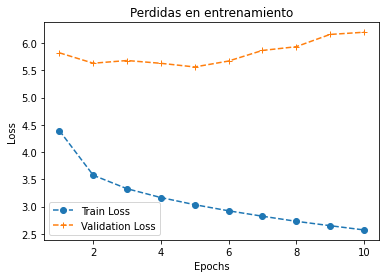

In [61]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), train_loss, '--o', label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, '--+', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Perdidas en entrenamiento')

## 1c) Generación de texto

In [97]:
# Acá tu código para generar texto usando el modelo
from torch.distributions.categorical import Categorical
import random
import torch.nn.functional as F


def generate_sentence(model, 
                      init_sentence= None, 
                      max_len=None):
  # Usa acá lo que necesites para crear una secuencia de
  # salida. Muy posiblemente tendrás que usar un tokenizador
  # y el diccionario para pasar de índices a tokens (palabras).
  # model.predict()
  if max_len is None:
    max_len = random.randint(5,15)
  if init_sentence is None:
    init_sentence = test_text[random.randint(0, len(test_text))]

  sentence = init_sentence
  for k in range(max_len):
    init_tokens, _ = tokenize_text([sentence], tokenizer)
    Data = torch.tensor(encode_sentences(init_tokens, vocab, word2idx)).cuda()
    logits_data = model.forward(Data.T).view(-1, voc_size)
    logits_index_max = torch.max(F.softmax(logits_data, dim=1), dim=1)[1]
    
    next_word = vocab[logits_index_max[-2]]
    
    if next_word == '.':
      sentence += next_word
      break
    else:
      sentence += ' ' + next_word 
  return sentence

### Para las pruebas, se utilizaran oraciones tanto del `test set` como custom:

In [95]:
model = net

In [96]:
for i in range(4):
  oracion_inicial = test_text[random.randint(0, len(test_text))]
  largo_inicial = random.randint(1, len(oracion_inicial)-1)
  print(f'Oracion generada: \n {generate_sentence(model, oracion_inicial)}')

Oracion generada: 
 The young girl is standing on a skateboard..
Oracion generada: 
 A woman grabbing her feet while jumping in front of trees..
Oracion generada: 
 A possible woman dressed as a belly dancer holds out a cloth with beads on it..
Oracion generada: 
 Two girls play outside with chalk..


In [91]:
print(generate_sentence(model))

A black puppy is playing with an orange on a carpeted floor..


## 1d) Opcional: Beam Search

In [ ]:
# Acá tu código para generar texto usando beam search

def beam_search_generation(model, init_sentence, K, ...):
  # El K representa al ancho del beam para la búsqueda.
  return sentence

# Parte 2 (Opcional): Subtitulado de imágenes

#### Generamos transformación para el dataset

Algo importante es que estamos usando la normalización estándar para los modelos pre-entrenados que provee pytoch. Si vas a usar algún otro modelo (o incluso uno generado por ti), podrías necesitar otra normalización. También nota que estamos usando el tamaño estándar de `224x224` para las imágenes que reciben los modelos pre-entrenados de pytorch. Si no quieres usar esos modelos o si quieres hacer el entrenamiento más rápido, puedes cambiarle la resolución a las imágenes.

In [ ]:
transform = transforms.Compose(
            [
              transforms.ToTensor(), 
              transforms.Resize((224, 224)),
              transforms.Normalize(
                  mean=[0.485, 0.456, 0.406], 
                  std=[0.229, 0.224, 0.225])
            ])

#### Creamos los data loaders (puedes cambiar el tamaño del batch si lo deseas)

In [ ]:
batch_size = 16

train_dataloader = DataLoader(
    CaptioningDataset(
        train_flickr_set, transform, tokenizer, word2idx, "<sos>", "."),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: pad_sequence_with_images(x, pad_idx)
    )

test_dataloader = DataLoader(
    CaptioningDataset(
        test_flickr_set, transform, tokenizer, word2idx, "<sos>", "."),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: pad_sequence_with_images(x, pad_idx)
    )

val_dataloader = DataLoader(
    CaptioningDataset(
        val_flickr_set, transform, tokenizer, word2idx, "<sos>", "."),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: pad_sequence_with_images(x, pad_idx)
    )

**IMPORTANTE**: Nuestros dataloaders ahora contienen las secuencias de identificadores de los tokens del texto, los largos de las secuencias y las imágenes correspondientes. El siguiente código obtiene el primer elemento del dataloader de prueba. Nota que lo que entregan en ambos casos es una tripleta: la primera componente tiene los datos desde los textos (los índices), la segunda componente tiene información de los largos de las secuencias, y la tercera componente la información de las imágenes.

In [ ]:
# Obtiene un paquete desde el dataloader
for data in test_dataloader:
  Text, Lengths, Img = data
  break

print(Text.size())
print(Lengths.size())
print(Img.size())

# La primera dimensión de Text corresponde al largo
# máximo de las secuencias en el batch
assert Text.size()[0] == torch.max(Lengths)

# La segunda dimensión de D corresponde al tamaño del
# batch, al igual que la dimensión de Lengths y la primera
# dimensión de Img
assert Text.size()[1] == batch_size 
assert Lengths.size()[0] == batch_size
assert Img.size()[0] == batch_size

### Usando modelos pre-entrenados

El siguiente código carga VGG16 (pre-entrenado), pasa el modelo a la GPU. 

In [ ]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
vgg16 = vgg16.to('cuda')

Con un codigo como el siguiente podemos calcular las características para las imágenes `Img` del batch que obtuvimos más arriba. Nota el uso de `.eval()` y `with torch.no_grad()`.

In [ ]:
Img = Img.to('cuda')

vgg16.eval()
with torch.no_grad():
  F = vgg16.features(Img)

print(F.size())

Finalmente y por si lo necesitas, puedes acceder a las imágenes originales del dataloader haciendo algo como esto:

In [ ]:
val_dataloader.dataset.original_image(0)

## 2a) Red convolucional + recurrente

In [ ]:
class CaptioningModel(torch.nn.Module):
    def __init__(self, ...): 
        # Crea las capas considerando una parte que procese debe procesar
        # la imagen de entrada y otra que debe producir el texto (índices)
        # de salida.
        pass
        
    def forward(self, ...):
        # Acá debes programar la pasada hacia adelante.
        # Debes decidir qué le pasarás a la red y cómo haras la 
        # computación hacia adelante. Considera que no solo
        # debes entrenar los parámetros sino que además debes
        # después ser capaz de generar una secuencia de salida
        # desde una imagen de entrada.
        return ...   

## 2b) Entrenamiento

In [ ]:
# Acá tu código para el loop de entrenamiento
# y los gráficos de la pérdida

## 2c) Generando texto desde imágenes de prueba


In [ ]:
# Acá tu código para generar texto usando desde imágenes
# y un par de ejemplos con las imágenes del conjunto de prueba